In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import chain
from collections import Counter

In [2]:
# Load data
train = pd.read_csv('../data/train.csv', index_col='ex_id')
val = pd.read_csv('../data/dev.csv', index_col='ex_id')
test = pd.read_csv('../data/test_no_label.csv', index_col='ex_id')

# Load tokenized data
train_data_tokens = pkl.load(open("../data/tokens/train_data_tokens.pkl", "rb"))
val_data_tokens = pkl.load(open("../data/tokens/val_data_tokens.pkl", "rb"))
test_data_tokens = pkl.load(open("../data/tokens/test_data_tokens.pkl", "rb"))

all_train_tokens = list(chain.from_iterable(train_data_tokens))

# Get labels
y_train = train.label.values
y_val = val.label.values
y_test = test.label.values

In [3]:
# Vocab
def build_vocab(all_tokens, threshold):

    c = Counter(all_tokens)
    vocab = [word for count, word in enumerate(Counter(all_train_tokens)) if count >= 10]
    
    id2token = vocab
    token2id = dict(zip(vocab, range(len(vocab))))
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, 10)

In [4]:
# TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy(doc):
    return doc

tfidf_vec = TfidfVectorizer(lowercase=False, preprocessor=dummy, tokenizer=dummy, vocabulary=token2id)  

X_train_tfidf = tfidf_vec.fit_transform(train_data_tokens)
X_val_tfidf = tfidf_vec.transform(val_data_tokens)
X_test_tfidf = tfidf_vec.transform(test_data_tokens)

### Latent Factor Model

In [18]:
from surprise import SVD
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

In [19]:
# Get train data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[['user_id', 'prod_id', 'rating']], reader)

In [20]:
# Get val data
testset = Dataset.load_from_df(val[['user_id', 'prod_id', 'rating']], reader)
_, testset = train_test_split(testset, test_size=1.)

### Hyperparameter search

#### 1. Rough search

In [33]:
# Rough search
rank_list = [50, 100, 200, 400]
reg_list = [0.001, 0.01, 0.1, 1]
result = {}

for rank in rank_list:
    for reg in reg_list:
        print(f'Training with rank {rank} and reg {reg}')
        algo = SVD(n_factors=rank, reg_all=reg)
        algo.fit(data.build_full_trainset())
        predictions = algo.test(testset)
        rmse = accuracy.rmse(predictions)
        if rank in result:
            result[rank].append(rmse)
        else:
            result[rank] = [rmse]

Training with rank 50 and reg 0.001
RMSE: 1.0594
Training with rank 50 and reg 0.01
RMSE: 1.0447
Training with rank 50 and reg 0.1
RMSE: 1.0283
Training with rank 50 and reg 1
RMSE: 1.0312
Training with rank 100 and reg 0.001
RMSE: 1.0667
Training with rank 100 and reg 0.01
RMSE: 1.0538
Training with rank 100 and reg 0.1
RMSE: 1.0287
Training with rank 100 and reg 1
RMSE: 1.0313
Training with rank 200 and reg 0.001
RMSE: 1.0752
Training with rank 200 and reg 0.01
RMSE: 1.0569
Training with rank 200 and reg 0.1
RMSE: 1.0299
Training with rank 200 and reg 1
RMSE: 1.0313
Training with rank 400 and reg 0.001
RMSE: 1.0826
Training with rank 400 and reg 0.01
RMSE: 1.0635
Training with rank 400 and reg 0.1
RMSE: 1.0310
Training with rank 400 and reg 1
RMSE: 1.0314


In [34]:
result

{50: [1.0593586396339603,
  1.044663904014853,
  1.0282657404728706,
  1.0312141442772111],
 100: [1.0666732917935169,
  1.053837992738709,
  1.0287083669761958,
  1.0312515353128495],
 200: [1.075191951671995,
  1.0568684221973264,
  1.0298537205797462,
  1.031287621034606],
 400: [1.082625781457039,
  1.0634642598530313,
  1.030986122404164,
  1.0313679327341458]}

#### 2. Zoom in, from 10 to 190 inclusive

In [41]:
rank_list = list(range(10, 200, 10))
reg = 0.1
result = []

for rank in rank_list:
    print(f'Training with rank {rank} and reg {reg}')
    algo = SVD(n_factors=rank, reg_all=reg)
    algo.fit(data.build_full_trainset())
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    result.append(rmse)

Training with rank 10 and reg 0.1
RMSE: 1.0278
Training with rank 20 and reg 0.1
RMSE: 1.0278
Training with rank 30 and reg 0.1
RMSE: 1.0278
Training with rank 40 and reg 0.1
RMSE: 1.0280
Training with rank 50 and reg 0.1
RMSE: 1.0278
Training with rank 60 and reg 0.1
RMSE: 1.0279
Training with rank 70 and reg 0.1
RMSE: 1.0283
Training with rank 80 and reg 0.1
RMSE: 1.0285
Training with rank 90 and reg 0.1
RMSE: 1.0289
Training with rank 100 and reg 0.1
RMSE: 1.0287
Training with rank 110 and reg 0.1
RMSE: 1.0284
Training with rank 120 and reg 0.1
RMSE: 1.0287
Training with rank 130 and reg 0.1
RMSE: 1.0290
Training with rank 140 and reg 0.1
RMSE: 1.0290
Training with rank 150 and reg 0.1
RMSE: 1.0287
Training with rank 160 and reg 0.1
RMSE: 1.0296
Training with rank 170 and reg 0.1
RMSE: 1.0290
Training with rank 180 and reg 0.1
RMSE: 1.0294
Training with rank 190 and reg 0.1
RMSE: 1.0288


In [42]:
result

[1.0278462290110109,
 1.0277819203688963,
 1.0277629654690075,
 1.0280344715479133,
 1.02777423679093,
 1.0279465724011618,
 1.0283276522276261,
 1.0284789498066362,
 1.0289434988708062,
 1.028741030114539,
 1.0284358319557545,
 1.0287447170186415,
 1.0290124863744294,
 1.0289712150271977,
 1.028669870377683,
 1.0295726933373899,
 1.028959499625837,
 1.0294497863177827,
 1.028780790620609]

In [43]:
import matplotlib.pyplot as plt

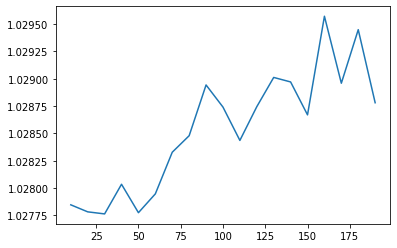

In [47]:
plt.plot(rank_list, result)
# plt.xticks(rank_list)
plt.show()

In [54]:
print(f'Best rank is {rank_list[result.index(min(result))]}, RMSE is {min(result)}')

Best rank is 30, RMSE is 1.0277629654690075


In [59]:
rank_list[4], result[4]

(50, 1.02777423679093)

#### Further zoom in, rank from 1 to 50

In [63]:
# Further zoom in

rank_list = list(range(1, 51)) # from 1 to 50 inclusive
reg = 0.1
result = []

for rank in rank_list:
    print(f'Training with rank {rank} and reg {reg}')
    algo = SVD(n_factors=rank, reg_all=reg)
    algo.fit(data.build_full_trainset())
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    result.append(rmse)

Training with rank 1 and reg 0.1
RMSE: 1.0276
Training with rank 2 and reg 0.1
RMSE: 1.0276
Training with rank 3 and reg 0.1
RMSE: 1.0276
Training with rank 4 and reg 0.1
RMSE: 1.0276
Training with rank 5 and reg 0.1
RMSE: 1.0276
Training with rank 6 and reg 0.1
RMSE: 1.0276
Training with rank 7 and reg 0.1
RMSE: 1.0277
Training with rank 8 and reg 0.1
RMSE: 1.0276
Training with rank 9 and reg 0.1
RMSE: 1.0277
Training with rank 10 and reg 0.1
RMSE: 1.0276
Training with rank 11 and reg 0.1
RMSE: 1.0276
Training with rank 12 and reg 0.1
RMSE: 1.0277
Training with rank 13 and reg 0.1
RMSE: 1.0278
Training with rank 14 and reg 0.1
RMSE: 1.0278
Training with rank 15 and reg 0.1
RMSE: 1.0278
Training with rank 16 and reg 0.1
RMSE: 1.0278
Training with rank 17 and reg 0.1
RMSE: 1.0277
Training with rank 18 and reg 0.1
RMSE: 1.0278
Training with rank 19 and reg 0.1
RMSE: 1.0278
Training with rank 20 and reg 0.1
RMSE: 1.0277
Training with rank 21 and reg 0.1
RMSE: 1.0278
Training with rank 22 

In [64]:
result

[1.0275801292311055,
 1.0275510512658792,
 1.0275751940450133,
 1.0276328222919031,
 1.027590865378108,
 1.0275814318082095,
 1.0277147894917942,
 1.0276462117638574,
 1.0277139526952195,
 1.0276327802040068,
 1.0276051049772224,
 1.0277175655870054,
 1.0278294275835227,
 1.0277720001786887,
 1.0278004088669543,
 1.0278261011028795,
 1.027744130465523,
 1.02779604838231,
 1.0277742448995608,
 1.0277162127598949,
 1.0277560266544752,
 1.027861276199262,
 1.027976968190892,
 1.0277218738131972,
 1.0275430540151373,
 1.0277782137574967,
 1.028062368699627,
 1.0278775206736634,
 1.0278703575379464,
 1.0279783239613003,
 1.0278497490039014,
 1.0276760194917969,
 1.0281721140044016,
 1.0279998512177586,
 1.0277933457315516,
 1.0277265683329,
 1.0280505218436613,
 1.0281768338481296,
 1.0282146719018348,
 1.02809210897026,
 1.0280429040468382,
 1.0280162782843918,
 1.0282071060099405,
 1.02807163955889,
 1.0282690102710763,
 1.028292156574374,
 1.0278648076414296,
 1.028094786171722,
 1.02803

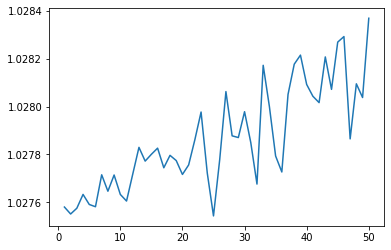

In [65]:
plt.plot(rank_list, result)
# plt.xticks(rank_list)
plt.show()

In [66]:
print(f'Best rank is {rank_list[result.index(min(result))]}, RMSE is {min(result)}')

Best rank is 25, RMSE is 1.0275430540151373


### Train with the best config

In [69]:
rank = 25
reg = 0.1

algo = SVD(n_factors=rank, reg_all=reg)
algo.fit(data.build_full_trainset())
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 1.0278


In [70]:
user_factors = algo.pu
product_factors = algo.qi

In [72]:
len(user_factors)

125679

In [78]:
train['user_id'].unique().shape

(125679,)

In [79]:
len(product_factors)

923

In [82]:
train['prod_id'].unique().shape

(923,)